# Test Features
Idea, feed two different images and inspect their activation

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import models
import utils_resnet_TL as utils_resnet
import change_dataset_np
import matplotlib.pyplot as plt
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
img_size = 224
batch_size = 1
val_pickle_file = 'change_dataset_train.pkl'

from IPython.display import clear_output, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [20]:
#transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [21]:
val_dataset = change_dataset_np.ChangeDatasetNumpy(val_pickle_file, data_transforms['val'])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

#### Initialize Featues Extractor (Resnet 50)

In [4]:
ResnetFeatures = utils_resnet.resnet50(models.ResnetFeatures, pretrained=True)
# Freeze Layers
ResnetFeatures.set_parameter_requires_grad(feature_extracting=True)
ResnetFeatures.eval();

#### Initialize UpSample layer

In [5]:
upsample = nn.UpsamplingBilinear2d(size=(img_size, img_size))

#### Select reference/test image

In [17]:
iteractive_idx = 0
@interact(idx=widgets.IntSlider(min=0,max=len(val_dataset)-1))
def explore_validation_dataset(idx):
    global iteractive_idx
    sample = val_dataset[idx]
    reference_img = sample['reference']
    test_img = sample['test']
    label_img = sample['label'].squeeze(0)
    print(label_img.shape)
    plt.imshow(reference_img.permute(1, 2, 0).numpy())
    plt.show()
    plt.imshow(test_img.permute(1, 2, 0).numpy())
    plt.show()
    plt.imshow(label_img.numpy())
    plt.show()
    iteractive_idx = idx

interactive(children=(IntSlider(value=0, description='idx', max=73275), Output()), _dom_classes=('widget-inter…

#### Get features and display

In [22]:
sample = val_dataset[iteractive_idx]
reference_img = sample['reference']
test_img = sample['test']
label_img = sample['label'].squeeze(0)

features_reference = ResnetFeatures(reference_img.unsqueeze(0))
_, cp3_ref,cp4_ref,cp5_ref = features_reference
features_test = ResnetFeatures(test_img.unsqueeze(0))
_, cp3_test,cp4_test,cp5_test = features_test

# Bring all features to the same size
cp3_ref = upsample(cp3_ref)
cp3_test = upsample(cp3_test)
cp4_ref = upsample(cp4_ref)
cp4_test = upsample(cp4_test)
cp5_ref = upsample(cp5_ref)
cp5_test = upsample(cp5_test)

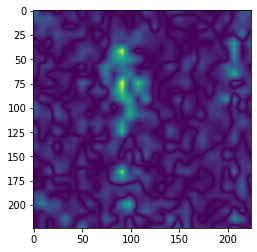

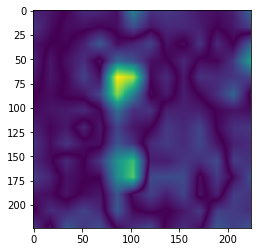

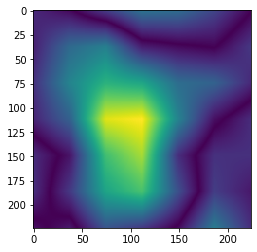

In [28]:
diff_cp3 = torch.abs(torch.sum(cp3_ref.squeeze(0), dim=0) - torch.sum(cp3_test.squeeze(0), dim=0))
diff_cp4 = torch.abs(torch.sum(cp4_ref.squeeze(0), dim=0) - torch.sum(cp4_test.squeeze(0), dim=0))
diff_cp5 = torch.abs(torch.sum(cp5_ref.squeeze(0), dim=0) - torch.sum(cp5_test.squeeze(0), dim=0))

plt.imshow(diff_cp3)
plt.show()
plt.imshow(diff_cp4)
plt.show()
plt.imshow(diff_cp5)
plt.show()

In [ ]:
27004